In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
import os
sys.path.append(os.getenv("HOME") + "/git/github.com/dnswlt/hexz/pyhexz/src")

In [3]:
from pyhexz import modelrepo
from pyhexz.hexc import CBoard
from pyhexz.hexz import HexzNeuralNetwork

In [11]:
repo = modelrepo.LocalModelRepository(os.getenv("HOME") + "/git/github.com/dnswlt/hexz-models")

In [119]:
model = repo.get_model("harlem")
#model = HexzNeuralNetwork()
_ = model.train()

In [49]:
board = CBoard()

In [79]:
pr_loss_fn = nn.CrossEntropyLoss()
val_loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(
            model.parameters(),
            lr=1e-3,
            weight_decay=1e-4
        )

In [115]:
b = torch.from_numpy(board.b)
assert b.shape == (11, 11, 10)
action_mask = torch.stack((1 - b[2], torch.zeros((11,10)))).bool()
assert action_mask.shape == (2, 11, 10)

optimizer.zero_grad()
pred_pr, pred_val = model(b.unsqueeze(0), action_mask.unsqueeze(0))
pred_pr.sum().backward()
#pr_loss = pr_loss_fn(pred_pr.flatten(1), y_pr.flatten(1))
#val_loss = val_loss_fn(pred_val, y_val)
#loss = pr_loss + val_loss
#loss.backward()

In [54]:
ps = list(model.parameters())

In [55]:
len(ps)

27

In [56]:
len(model.state_dict())

48

In [58]:
next(iter(model.state_dict()))

'cnn_blocks.0.0.weight'

cnn_blocks.1.1.running_var <class 'torch.Tensor'> torch.float32


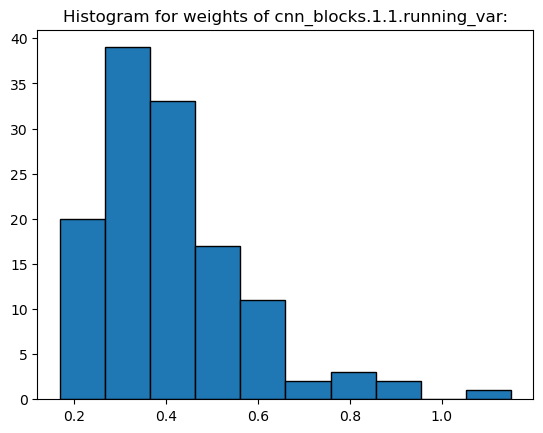

cnn_blocks.1.1.num_batches_tracked <class 'torch.Tensor'> torch.int64
skipping dict entry cnn_blocks.1.1.num_batches_tracked with type torch.int64
cnn_blocks.2.0.weight <class 'torch.Tensor'> torch.float32


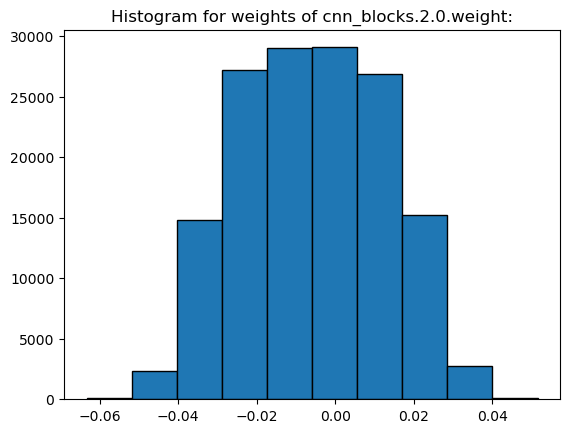

cnn_blocks.2.1.weight <class 'torch.Tensor'> torch.float32


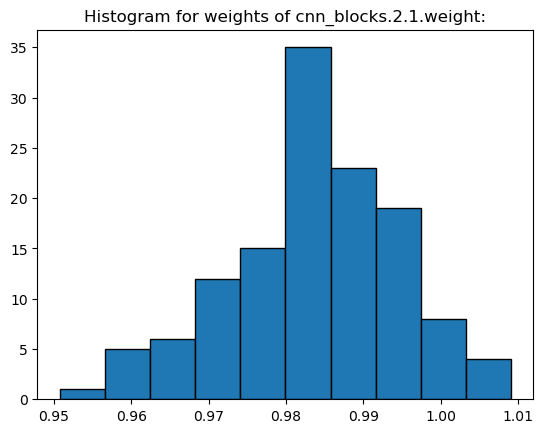

cnn_blocks.2.1.bias <class 'torch.Tensor'> torch.float32


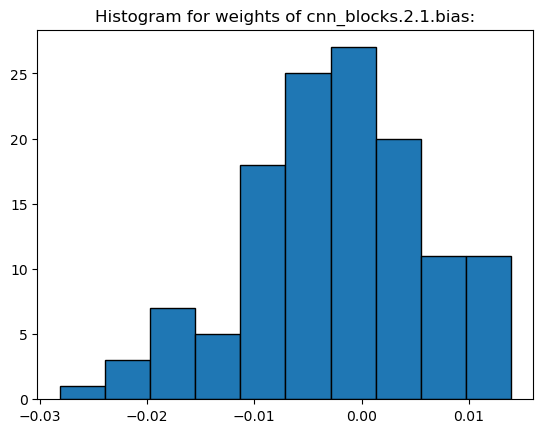

cnn_blocks.2.1.running_mean <class 'torch.Tensor'> torch.float32


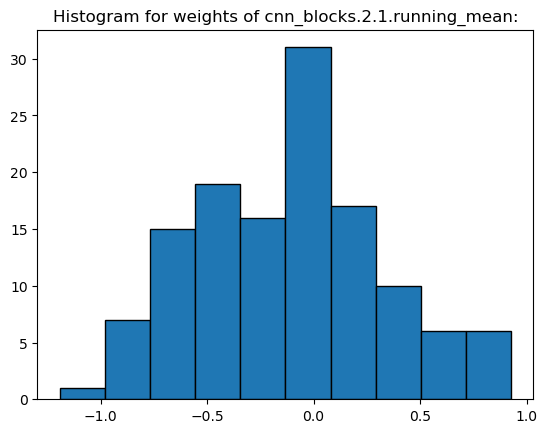

In [98]:
# Histogram of weight values
for i, (key, ws) in enumerate(model.state_dict().items()):
    if i < 10 or i > 15:
        continue
    print(key, type(ws), ws.dtype)
    if ws.dtype not in [torch.float32]:
        print(f"skipping dict entry {key} with type {ws.dtype}")
        continue
    hist, edges = torch.histogram(ws.flatten(), bins=10)
    plt.bar(edges[:-1], hist, width=edges[1]-edges[0], edgecolor='black')
    plt.title(f"Histogram for weights of {key}:")
    plt.show()


In [120]:
def gradient_hook(module, input_grad, output_grad):
    print(module, output_grad[0].abs().mean().item())

try:
    hook_handles = [None] * len(model.cnn_blocks)
    for i, block in enumerate(model.cnn_blocks):
        hook_handles[i] = block.register_full_backward_hook(gradient_hook)
    optimizer.zero_grad()
    pred_pr, pred_val = model(b.unsqueeze(0), action_mask.unsqueeze(0))
    pred_pr.sum().backward()
finally:
    for h in hook_handles:
        h.remove()

Sequential(
  (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
) 0.019482463598251343
Sequential(
  (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
) 0.009648725390434265
Sequential(
  (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
) 0.007945925928652287
Sequential(
  (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
) 0.015908150002360344
Sequential(
  (0): Conv2d(11, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (1): BatchNorm

In [5]:
# Read AddTrainingExampleRequest files and check their stats

In [9]:
f = "/tmp/checkpoints/7/examples/20231118_185920_114917.gz"

In [114]:
import glob
from collections import defaultdict

def read_reqs(model="edgar"):
    """Read all AddTrainingExamplesRequest files."""
    result = []
    efiles = glob.glob(f"/tmp/hexz-models/models/flagz/{model}/checkpoints/*/examples/*.gz")
    for f in efiles:
        r = hexz_pb2.AddTrainingExamplesRequest.FromString(gzip.open(f).read())
        result.append(r)
    return result

def filter_ex(reqs, move=[], cp=[]):
    """Returns a list of TrainingExample from the given AddTrainingExamplesRequest list,
    filtered by the specified criteria.
    """
    cps = cp if isinstance(cp, list) else [cp]
    moves = move if isinstance(move, list) else [move]
    def p(r, e):
        return (
            (not cps or r.model_key.checkpoint in cps) and
            (not moves or e.move.move in moves)
        )
    es = []
    for r in reqs:
        for e in r.examples:
            if p(r, e):
                es.append(e)
    return es

reqs = read_reqs()
d = defaultdict(lambda: [])
for r in reqs:
    d[r.model_key.checkpoint].append(r)
epc = { k: len(v) for k, v in d.items() }
print(f"Examples per checkpoint: {epc}")

Examples per checkpoint: {0: 30, 6: 25, 1: 25, 4: 25, 3: 25, 2: 24, 5: 25}


In [30]:
import gzip
from pyhexz import hexz_pb2
from pyhexz import training

In [68]:
# Avg. number of examples per request
sum(len(t.examples) for t in reqs) / len(reqs)

41.072625698324025

Displaying 1074 move probs


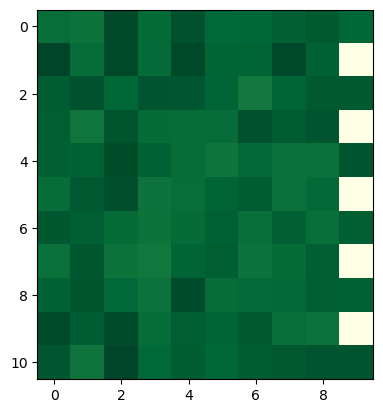

In [124]:
moves=[0,1,2,3,4,5]
checkpoints = []
prs = [training.NumpyExample.decode(e).move_probs for e in filter_ex(reqs, move=moves, cp=checkpoints)]
print(f"Displaying {len(prs)} move probs")
Xs = np.array(prs)
S = Xs.mean(axis=0)
F = S[0]
plt.imshow(F, cmap='YlGn', interpolation='nearest')

In [125]:
Fmin = F[F.nonzero()].min()
print(f"Min/max nonzero move probs in %:\nmin: {Fmin*100}\nmax: {F.max()*100}")

Min/max nonzero move probs in %:
min: 0.8212056942284107
max: 1.0206259787082672


In [126]:
bs = [training.NumpyExample.decode(e).board for e in filter_ex(reqs, move=moves, cp=checkpoints)]

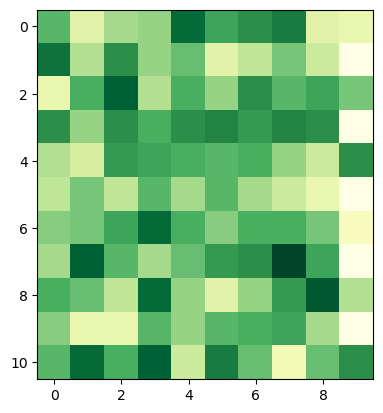

In [128]:
M = np.array([b[5] for b in bs]).sum(axis=0)
plt.imshow(M, cmap='YlGn', interpolation='nearest')

In [129]:
M, M.sum()

(array([[16.,  6., 11., 12., 24., 18., 20., 22.,  6.,  5.],
        [23., 10., 20., 12., 15.,  6.,  9., 14.,  8.,  0.],
        [ 5., 17., 25., 10., 17., 12., 20., 16., 18., 14.],
        [20., 12., 20., 17., 20., 21., 19., 21., 20.,  0.],
        [10.,  7., 19., 18., 17., 16., 17., 12.,  8., 20.],
        [ 9., 14.,  9., 16., 11., 16., 11.,  8.,  5.,  0.],
        [13., 14., 18., 24., 17., 13., 17., 17., 14.,  3.],
        [11., 25., 16., 11., 15., 19., 20., 28., 18.,  0.],
        [17., 15.,  9., 24., 12.,  6., 12., 19., 26., 10.],
        [13.,  5.,  5., 16., 12., 16., 17., 18., 11.,  0.],
        [16., 24., 17., 25.,  8., 22., 15.,  4., 15., 20.]], dtype=float32),
 1566.0)